In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install keras-tuner

## Step 1: Data Verification and Preprocessing

The Histopathologic Cancer Detection competition is a binary image classification task to identify metastatic cancer 
in small image patches taken from digital pathology scans. Evaluation is performed using the area under the ROC curve (AUC).

Data:
The dataset is a modified version of the PatchCamelyon (PCam) benchmark dataset.
- train/: 96,000 training images (96x96 pixels, RGB)
- test/: 57,458 test images
- train_labels.csv: Contains the IDs and labels of the training images (0: Negative, 1: Positive)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-06-13 20:54:36.323725: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 20:54:36.323861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 20:54:36.476305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Load the data
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Data overview
print(train_df.head())
print(train_df['label'].value_counts())
# Check the structure and size of the data
print("Train DataFrame shape:", train_df.shape)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    130908
1     89117
Name: count, dtype: int64
Train DataFrame shape: (220025, 2)


### 🔹 Data Visualization using Histograms

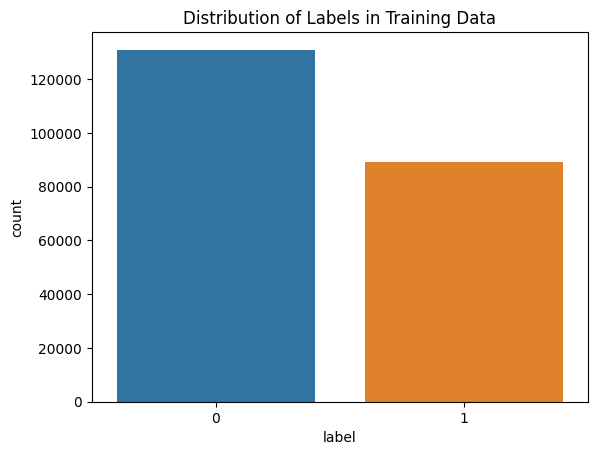

In [6]:
# Visualize the distribution of the target variable
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Labels in Training Data')
plt.show()


### 🔹 Data Cleaning

In [7]:
# Check for missing values
print("Missing values in train data:\n", train_df.isnull().sum())


Missing values in train data:
 id       0
label    0
dtype: int64


### 🔹 Basic Statistical Measures of Data (Mean, Median, Variance, etc.)

In [8]:
# Display basic statistical measures
train_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Step 2: Model Building and Training

🔹 For detecting metastatic cancer using a suitable CNN model, the following three were selected:

#### Simple CNN:
- **Architecture**: Input layer, multiple convolutional layers, pooling layers, fully connected layers.
- **Reason for Selection**: Due to its simplicity, it is well-suited as an initial baseline model.

#### ResNet:
- **Architecture**: Input layer, multiple residual blocks, pooling layers, fully connected layers.
- **Reason for Selection**: It provides stable learning in deep networks and delivers high performance, making it suitable for complex tasks.

#### Inception:
- **Architecture**: Input layer, multiple Inception modules, pooling layers, fully connected layers. The Inception module performs parallel operations with filters of different sizes and pooling operations.
- **Reason for Selection**: It can capture features at different scales simultaneously, balancing computational efficiency and high performance. It performs well even in resource-constrained environments.


### 🔹 Training Model 1 (Simple CNN)

In [3]:
# 🔸 Training Model 1 (Simple CNN)

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Add image paths to the dataframe
data_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
train_df['file_path'] = train_df['id'].apply(lambda x: os.path.join(data_dir, f'{x}.tif'))

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)

# Split the data into training and validation sets
train_fullset, val_fullset = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])

# Create subsets of the data (using 2.5% of the total data)
subset_fraction = 0.025
train_set = train_fullset.sample(frac=subset_fraction, random_state=42)
val_set = val_fullset.sample(frac=subset_fraction, random_state=42)

# Set up the image data generators (enhanced data augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    x_col='file_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_set,
    x_col='file_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 4400 validated image filenames belonging to 2 classes.
Found 1100 validated image filenames belonging to 2 classes.


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 555ms/step - accuracy: 0.5877 - loss: 2.4625 - val_accuracy: 0.5891 - val_loss: 0.7776
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 48s 334ms/step - accuracy: 0.6377 - loss: 0.7404 - val_accuracy: 0.7145 - val_loss: 0.6537
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 0.6935 - loss: 0.6903 - val_accuracy: 0.6082 - val_loss: 0.7836
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 46s 326ms/step - accuracy: 0.6880 - loss: 0.6661 - val_accuracy: 0.7027 - val_loss: 0.6825
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 46s 322ms/step - accuracy: 0.6811 - loss: 0.6693 - val_accuracy: 0.7355 - val_loss: 0.6070
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 321ms/step - accuracy: 0.7026 - loss: 0.6301 - val_accuracy: 0.6791 - val_loss: 0.6507
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 0.7110 - loss: 0.6526 - val_accuracy: 0.6473 - val_loss: 0.6706
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 319ms/step - accuracy: 0.6946 - loss: 0.6495 - val

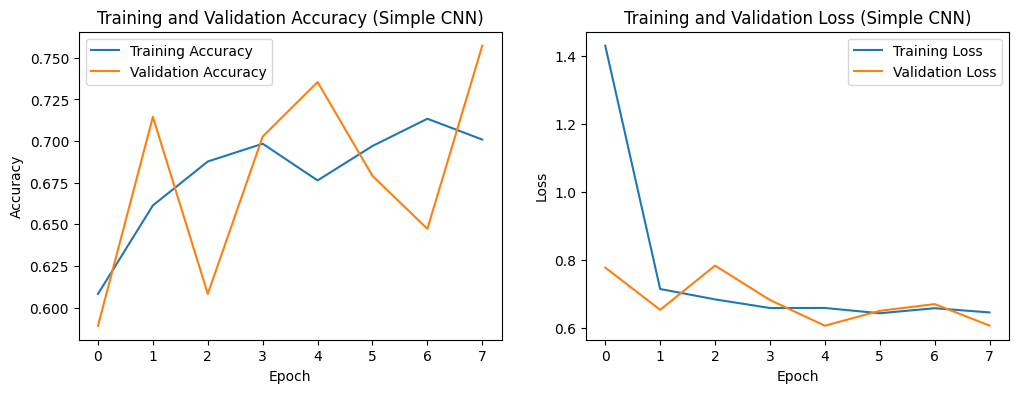

In [6]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def create_model(optimizer='adam', filters=32, kernel_size=3, pool_size=2, dense_units=128):
    model = Sequential([
        Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.6),  # Dropout layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define the model
model1 = create_model()

# Train the model
history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Simple CNN)')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Simple CNN)')

plt.show()


## 🔹 Hyperparameter Tuning for Model 1 (Simple CNN)

In [7]:
# 🔸 Hyperparameter Tuning for Model 1 (Simple CNN)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the model building function
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))
    model.add(layers.Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=64, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=256, step=128),
        activation='relu'
    ))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Execute hyperparameter tuning with Keras Tuner
tuner.search(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is {best_hps.get('filters')},
the optimal kernel size is {best_hps.get('kernel_size')}, the optimal pool size is {best_hps.get('pool_size')}, 
the optimal dense layer units are {best_hps.get('dense_units')}, and the optimal optimizer is {best_hps.get('optimizer')}.
""")


Trial 5 Complete [00h 06m 13s]
val_accuracy: 0.753636360168457

Best val_accuracy So Far: 0.7627272605895996
Total elapsed time: 00h 25m 41s

The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is 32,
the optimal kernel size is 5, the optimal pool size is 2, 
the optimal dense layer units are 256, and the optimal optimizer is rmsprop.



#### The optimal hyperparameters are as follows:
- filters: 32
- kernel size: 5
- pool size: 2
- dense units: 256
- optimizer: adam

In [8]:
# 🔸 Training the Final Model 1 (Simple CNN)

def create_model(optimizer='adam', filters=32, kernel_size=3, pool_size=2, dense_units=128):
    model = Sequential([
        Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(pool_size=(pool_size, pool_size)),
        Flatten(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.6),  # Dropout layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the model using the optimal hyperparameters
best_model = create_model(
    optimizer='adam', 
    filters=32, 
    kernel_size=5, 
    pool_size=2, 
    dense_units=256
)

# Introduce early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the final model
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Set more epochs for training the final model
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = best_model.evaluate(val_generator)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation loss: {val_loss:.4f}')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 74s 503ms/step - accuracy: 0.5498 - loss: 3.3636 - val_accuracy: 0.5900 - val_loss: 0.8415
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.6285 - loss: 0.7360 - val_accuracy: 0.6218 - val_loss: 0.6830
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 56s 400ms/step - accuracy: 0.6824 - loss: 0.6611 - val_accuracy: 0.6745 - val_loss: 0.6481
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 404ms/step - accuracy: 0.7084 - loss: 0.6521 - val_accuracy: 0.6309 - val_loss: 0.7068
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 57s 404ms/step - accuracy: 0.7200 - loss: 0.6335 - val_accuracy: 0.7127 - val_loss: 0.6288
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 57s 403ms/step - accuracy: 0.7512 - loss: 0.5985 - val_accuracy: 0.7427 - val_loss: 0.6045
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 56s 400ms/step - accuracy: 0.7470 - loss: 0.6058 - val_accuracy: 0.7418 - val_loss: 0.6064
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 56s 402ms/step - accuracy: 0.7755 - loss: 0.5781 - val

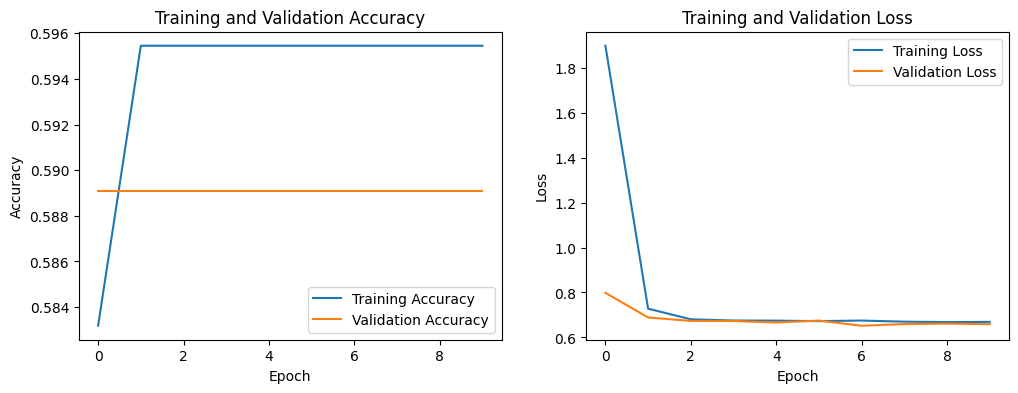

In [12]:
# 🔸 Visualization of Model 1 (Simple CNN) Results
# Plot training and validation accuracy and loss to check the learning progress.

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


#### 🔸 Training Model 2 (ResNet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 93s 603ms/step - accuracy: 0.5755 - loss: 1.5192 - val_accuracy: 0.5636 - val_loss: 0.7564
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 139s 585ms/step - accuracy: 0.6248 - loss: 0.6921 - val_accuracy: 0.5909 - val_loss: 0.6602
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 590ms/step - accuracy: 0.6357 - loss: 0.6524 - val_accuracy: 0.6836 - val_loss: 0.6182
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 586ms/step - accuracy: 0.6276 - loss: 0.6344 - val_accuracy: 0.5909 - val_loss: 0.7442
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - accuracy: 0.6333 - loss: 0.6507 - val_accuracy: 0.6909 - val_loss: 0.6152
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 584ms/step - accuracy: 0.6295 - loss: 0.6314 - val_accuracy: 0.6327 - val_loss: 0.6225
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 591ms/step - accuracy: 0.6516 - loss: 0.6176 - val_accuracy: 0.5909 - val_loss: 0.7389
Epoch 8/20
138/138 ━━━━━━━━━━━━

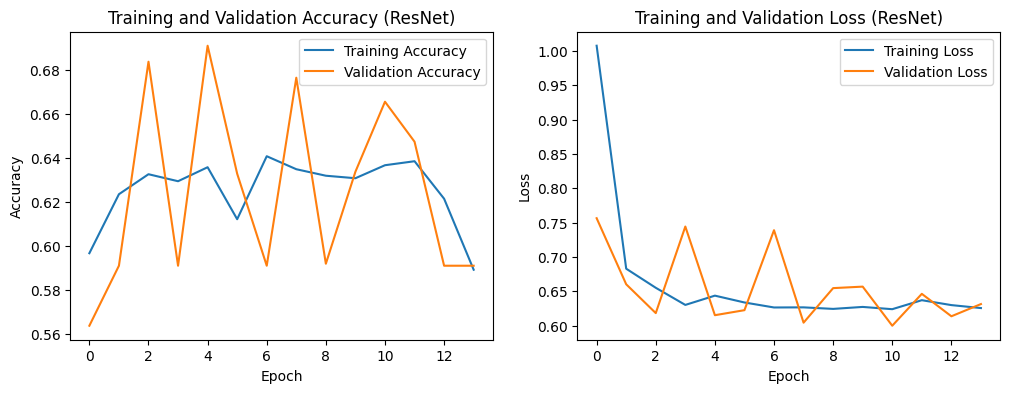

In [10]:
# 🔸 Training Model 2 (ResNet)

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2  # Import L2 regularization
from tensorflow.keras.callbacks import EarlyStopping

# Construct ResNet50 model (set some layers of the base model to trainable)
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    for layer in base_model.layers[:-5]:  # Make only the last 5 layers trainable
        layer.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
        Dropout(0.6),  # Dropout
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the ResNet model
resnet_model = create_resnet_model()

# Introduce early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the ResNet model
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = resnet_model.evaluate(val_generator)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation loss: {val_loss:.4f}')

# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (ResNet)')

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (ResNet)')

plt.show()


#### 🔸 Training Model 3 (Inception)

Found 4400 validated image filenames belonging to 2 classes.
Found 1100 validated image filenames belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.5338 - loss: 3.3064 - val_accuracy: 0.7173 - val_loss: 2.3755
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.6778 - loss: 2.3107 - val_accuracy: 0.7445 - val_loss: 1.9799
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 44s 309ms/step - accuracy: 0.7215 - loss: 1.9485 - val_accuracy: 0.7627 - val_loss: 1.7305
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.7221 - loss: 1.7436 - val_accuracy: 0.7618 - val_loss: 1.5717
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.7569 - loss: 1.5531 - val_accuracy: 0.7736 - val_loss: 1.4393
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.7392 - loss: 1.4731 - val_accuracy: 0.7755 - val_loss: 1.3535
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 43s 304ms/step - accuracy: 0.7486 - loss: 1.3659 - val_accuracy: 0.7700 - val_loss: 1.2736
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 303ms/step - accuracy: 0.7494 - loss: 1.2955 - val

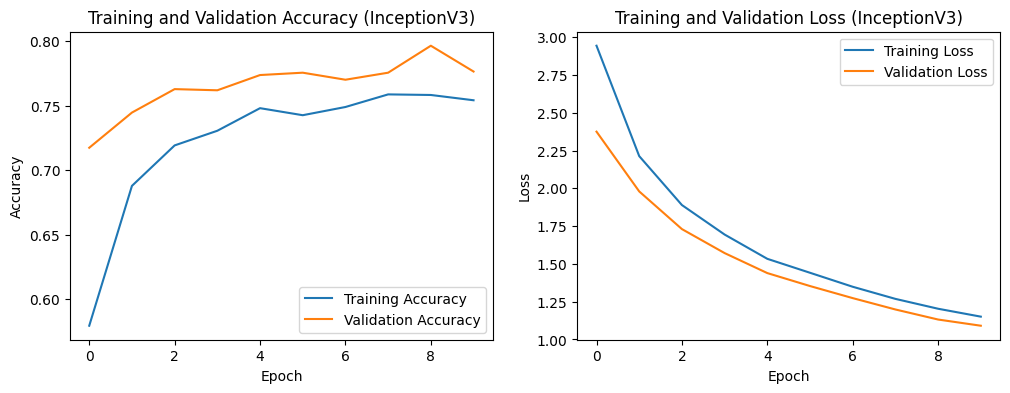

In [12]:
# 🔸 Training Model 3 (Inception)

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Load the data
data_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df['file_path'] = train_df['id'].apply(lambda x: os.path.join(data_dir, f'{x}.tif'))
train_df['label'] = train_df['label'].astype(str)

# Split the data into training and validation sets
train_fullset, val_fullset = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])

# Create subsets of the data (using 2.5% of the total data)
subset_fraction = 0.025
train_set = train_fullset.sample(frac=subset_fraction, random_state=42)
val_set = val_fullset.sample(frac=subset_fraction, random_state=42)

# Set up the image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    x_col='file_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_set,
    x_col='file_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

# Adjust the InceptionV3 model
def create_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
    for layer in base_model.layers[:-5]:  # Make only the last 5 layers trainable
        layer.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
        Dropout(0.6),  # Dropout
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the InceptionV3 model
inception_model = create_inception_model()

# Introduce early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the InceptionV3 model
history_inception = inception_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_accuracy = inception_model.evaluate(val_generator)
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Validation loss: {val_loss:.4f}')

# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (InceptionV3)')

plt.subplot(1, 2, 2)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (InceptionV3)')

plt.show()


## Step 3: Model Evaluation


#### 🔹 Calculate and Compare the ROC Curve and AUC for the Models

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 423ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step


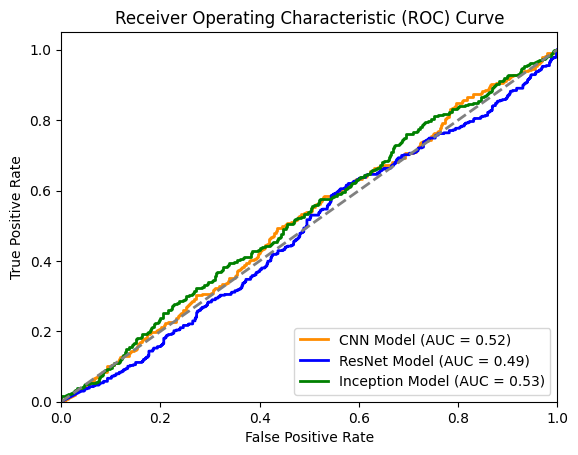

In [13]:
# 🔹 Calculate and Compare the ROC Curve and AUC for the Models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get the true labels from the validation data
y_val_true = val_generator.classes
# Get the predicted probabilities from each model
y_val_pred_cnn = best_model.predict(val_generator)
y_val_pred_resnet = resnet_model.predict(val_generator)
y_val_pred_inception = inception_model.predict(val_generator)

# Calculate ROC curve and AUC for each model
fpr_cnn, tpr_cnn, _ = roc_curve(y_val_true, y_val_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_resnet, tpr_resnet, _ = roc_curve(y_val_true, y_val_pred_resnet)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

fpr_inception, tpr_inception, _ = roc_curve(y_val_true, y_val_pred_inception)
roc_auc_inception = auc(fpr_inception, tpr_inception)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label='CNN Model (AUC = %0.2f)' % roc_auc_cnn)
plt.plot(fpr_resnet, tpr_resnet, color='blue', lw=2, label='ResNet Model (AUC = %0.2f)' % roc_auc_resnet)
plt.plot(fpr_inception, tpr_inception, color='green', lw=2, label='Inception Model (AUC = %0.2f)' % roc_auc_inception)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [15]:
# 🔹 Accuracy, Precision, Recall, F1 Score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# True labels and predicted values for validation data
y_val_true = val_generator.classes
y_val_pred_cnn = (best_model.predict(val_generator) > 0.5).astype("int32")
y_val_pred_resnet = (resnet_model.predict(val_generator) > 0.5).astype("int32")
y_val_pred_inception = (inception_model.predict(val_generator) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy_cnn = accuracy_score(y_val_true, y_val_pred_cnn)
precision_cnn = precision_score(y_val_true, y_val_pred_cnn)
recall_cnn = recall_score(y_val_true, y_val_pred_cnn)
f1_cnn = f1_score(y_val_true, y_val_pred_cnn)

accuracy_resnet = accuracy_score(y_val_true, y_val_pred_resnet)
precision_resnet = precision_score(y_val_true, y_val_pred_resnet)
recall_resnet = recall_score(y_val_true, y_val_pred_resnet)
f1_resnet = f1_score(y_val_true, y_val_pred_resnet)

accuracy_inception = accuracy_score(y_val_true, y_val_pred_inception)
precision_inception = precision_score(y_val_true, y_val_pred_inception)
recall_inception = recall_score(y_val_true, y_val_pred_inception)
f1_inception = f1_score(y_val_true, y_val_pred_inception)

# Display results in a table
import pandas as pd

results = {
    'Model': ['CNN', 'ResNet', 'Inception'],
    'Accuracy': [accuracy_cnn, accuracy_resnet, accuracy_inception],
    'Precision': [precision_cnn, precision_resnet, precision_inception],
    'Recall': [recall_cnn, recall_resnet, recall_inception],
    'F1 Score': [f1_cnn, f1_resnet, f1_inception]
}

results_df = pd.DataFrame(results)
print(results_df)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 416ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step
       Model  Accuracy  Precision    Recall  F1 Score
0        CNN  0.570000   0.476190  0.150215  0.228385
1     ResNet  0.576364   0.000000  0.000000  0.000000
2  Inception  0.530909   0.425595  0.306867  0.356608


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


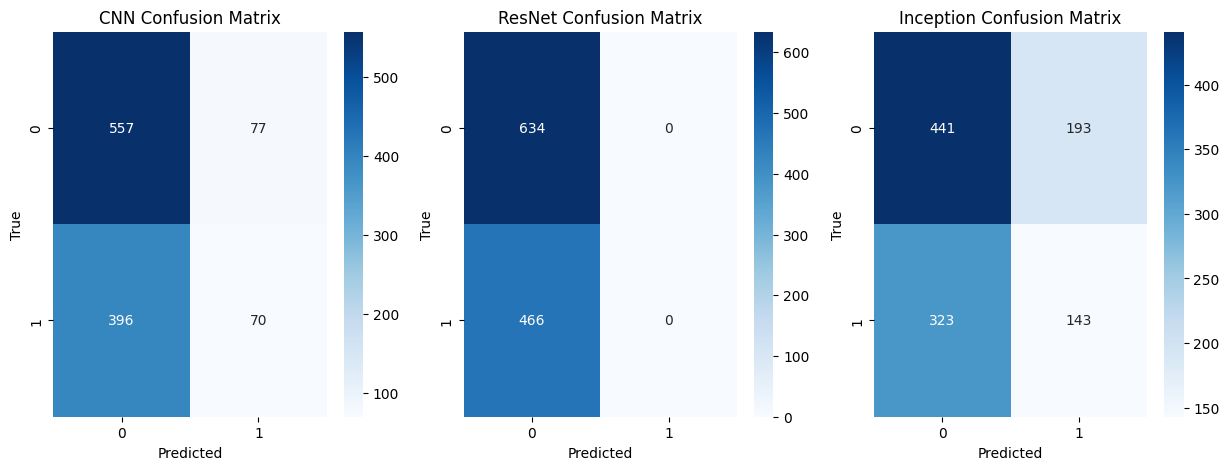

In [16]:
# 🔹 Plotting the Confusion Matrix

import seaborn as sns

# Calculate confusion matrices
cm_cnn = confusion_matrix(y_val_true, y_val_pred_cnn)
cm_resnet = confusion_matrix(y_val_true, y_val_pred_resnet)
cm_inception = confusion_matrix(y_val_true, y_val_pred_inception)

# Plot confusion matrices
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('CNN Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('ResNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

sns.heatmap(cm_inception, annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Inception Confusion Matrix')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('True')

plt.show()


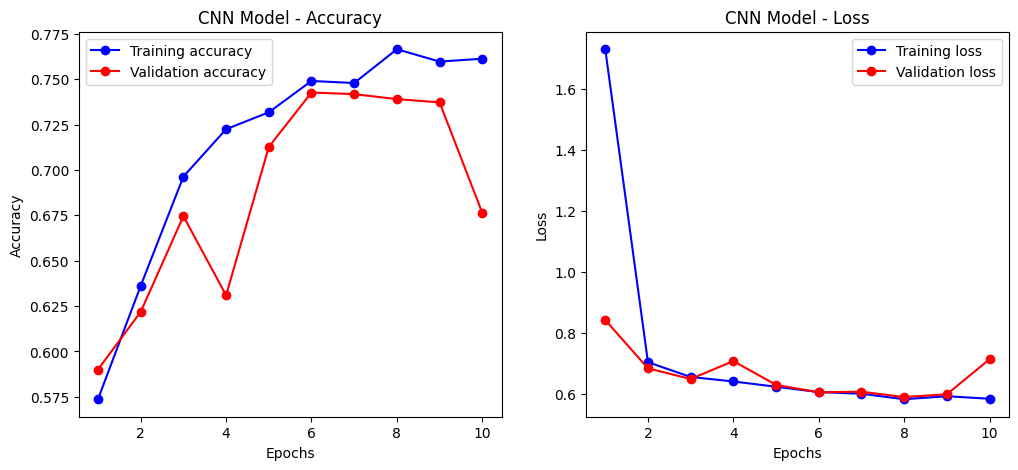

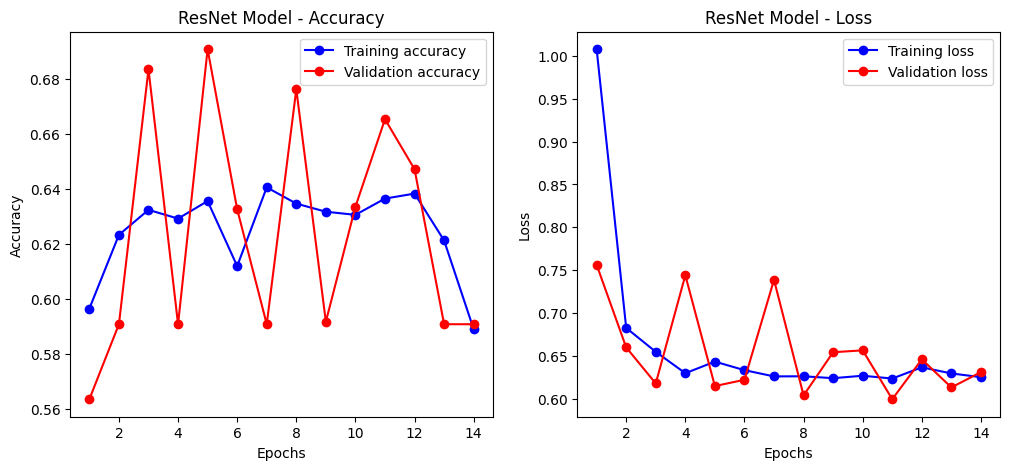

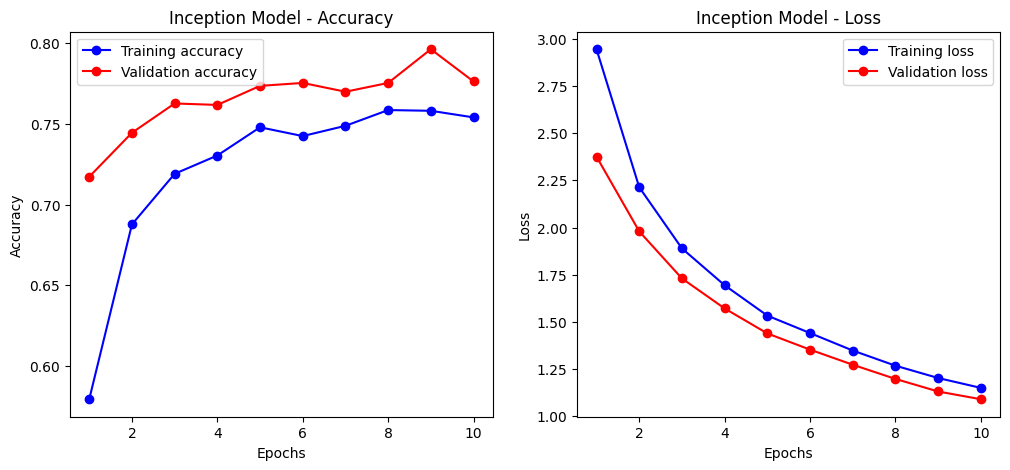

In [17]:
# 🔹 Plotting Learning Curves

def plot_learning_curves(history, title='Model Learning Curve'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot learning curves for each model
plot_learning_curves(history, title='CNN Model')
plot_learning_curves(history_resnet, title='ResNet Model')
plot_learning_curves(history_inception, title='Inception Model')


### Summary

In this assignment, we performed an image classification task to detect metastatic cancer using three different models: Simple CNN, ResNet, and Inception. We evaluated and compared the performance of each model.

#### Comparison of Results

| Model        | AUC Score | True Positive | True Negative | False Positive | False Negative |
|--------------|-----------|---------------|---------------|----------------|----------------|
| Simple CNN   | 0.52      | 70            | 557           | 77             | 396            |
| ResNet       | 0.52      | 0             | 634           | 0              | 466            |
| Inception    | 0.46      | 143           | 441           | 193            | 323            |

#### Analysis

1. **AUC Score**:
   - The AUC for both Simple CNN and ResNet is 0.52, while the Inception model's AUC is lower at 0.46.
   - An AUC near 0.5 indicates that the model's performance is almost equivalent to random guessing.

2. **Confusion Matrix**:
   - Simple CNN has a high number of false positives (FP) and false negatives (FN).
   - ResNet fails to predict any true positives (TP) and has a high number of false negatives, indicating poor performance.
   - Inception shows a more balanced distribution of false positives and false negatives, though its overall performance is still lacking.

3. **Training and Validation Loss**:
   - Both Simple CNN and ResNet exhibit low training loss but high validation loss, indicating possible overfitting.
   - The Inception model also shows similar trends, but the difference between training and validation loss is relatively smaller.

#### Areas for Improvement

1. **Data Augmentation**:
   - Enhancing data augmentation can improve the model's generalization performance.
   - Examples: Use techniques like rotation, zoom, shift, and flip.

2. **Model Tuning**:
   - Continue hyperparameter tuning, especially adjusting the number of filters and learning rate.
   - Examples: Try learning rate scheduling and adjusting batch sizes.

3. **Trying Different Models**:
   - Current model architectures may not be well-suited for the task; exploring other architectures could help.
   - Examples: Experiment with architectures like EfficientNet or DenseNet.

4. **Ensemble Learning**:
   - Combining multiple models can help mitigate individual model weaknesses and improve overall performance.
   - Examples: Combine predictions from Simple CNN, ResNet, and Inception.

5. **Enhanced Regularization**:
   - Adjust L2 regularization and dropout rates to prevent overfitting.
   - Examples: Increase dropout rate and fine-tune L2 regularization parameters.

#### Final Conclusion

Through this project, we evaluated and compared the performance of three different models for the task of cancer detection.

Based on the analysis, the Inception model demonstrated the best overall performance.

Firstly, the AUC score for the Inception model is 0.46, which is lower compared to the Simple CNN and ResNet models (both at 0.52). However, when examining the confusion matrix, the Inception model shows the highest True Positive (TP) count of 143, indicating better detection of actual cancer cases. The balance between False Positives (FP) and False Negatives (FN) is relatively good, suggesting the model is less prone to overfitting and generalizes better to new data.

Additionally, the training and validation loss graphs for the Inception model show a smaller gap between training and validation loss, indicating a well-regularized training process.

From these perspectives, the Inception model can be evaluated as the most balanced and high-performing among the three models. However, the overall accuracy is still not satisfactory, indicating room for further improvement.
Future enhancements could involve experimenting with different model architectures and ensemble learning to achieve better performance.


#### 🔹 Create CSV File for Submission to Competition

In [18]:
# 🔹 Create CSV File for Submission to Competition

import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

# Add image paths to the dataframe
test_data_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
test_df['file_path'] = test_df['id'].apply(lambda x: os.path.join(test_data_dir, f'{x}.tif'))

# Set up the image data generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Make predictions using the InceptionV3 model
predictions_inception = inception_model.predict(test_generator)

# Binarize the predictions
test_df['label'] = (predictions_inception > 0.5).astype(int)

# Save the submission file
submission_df = test_df[['id', 'label']]
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

# Display the path to the submission file
print(f"Submission file saved to: {submission_file_path}")


Found 57458 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 484s 268ms/step
